In [1]:
import mysql.connector
from functools import partial
import matplotlib.pyplot as plt
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='nlp',
    database='nlp',
)

def run_db_query(connection, query, args=None):
    with connection.cursor() as cursor:
        # print('Executando query:')
        cursor.execute(query, args)
        for result in cursor:
            print(result)

db = partial(run_db_query, connection)

## Entidades nomeadas

No contexto escolhido, algumas entidades nomeadas esperadas são coisas como nome de sites (Stack Overflow, Python.org, etc.) e também nomes de bibliotecas, como Beautiful Soup, Selenium, CSS Selectors, etc.

Primeiramente, foi pensado em usar term frequency de n-gramas de 2 a 3 palavras.

In [2]:
# db("SELECT content FROM Pages LIMIT 1")
with connection.cursor() as cursor:
    query = "SELECT content FROM Pages"
    cursor.execute(query, None)
    output = []
    for result in cursor:
        output.append(result[0])

In [3]:
vec = CountVectorizer(ngram_range=(2,3))
X = vec.fit_transform(output)

In [4]:
total_freq = X.sum(axis=0)
wf = {}
for k, v in vec.vocabulary_.items():
    wf[k] = total_freq[0,v]

In [5]:
wf = {k: v for k, v in sorted(wf.items(), key=lambda item: item[1], reverse = True)}

In [6]:
words = list(wf.keys())
for i in range(10):
    print(f"Palavra: '{words[i]}'\t\tContagem: {wf[words[i]]}")

Palavra: 'stack overflow'		Contagem: 8679
Palavra: 'public network'		Contagem: 8135
Palavra: 'stack exchange'		Contagem: 7759
Palavra: 'of the'		Contagem: 5389
Palavra: 'to the'		Contagem: 4749
Palavra: 'network terms'		Contagem: 4421
Palavra: 'public network terms'		Contagem: 4421
Palavra: 'these public'		Contagem: 3999
Palavra: 'these public network'		Contagem: 3999
Palavra: 'the public'		Contagem: 3606


A partir das contagens dos ngramas de tamanho 2 e 3, já é possível extrair algumas entidades nomeadas, como stack overflow e stack exchange. Pode-se ainda tentar aplicar outras técnicas como chunking, o que é feito abaixo.

In [18]:
from nltk import pos_tag
import nltk
import re


def prepro(word: str) -> str:
    o = re.sub("[\s|\n|\W]+", " ", word)
    o = ' '.join([i.lower() for i in o.split(' ') if not i.isdigit()])
    return o

pos_in = " ".join([prepro(o) for o in output])

pos_output = pos_tag(pos_in.split(' '), lang="eng", tagset="universal")
pos_output[:100]

[('teams', 'NOUN'),
 ('q', 'VERB'),
 ('a', 'DET'),
 ('for', 'ADP'),
 ('work', 'NOUN'),
 ('connect', 'NOUN'),
 ('and', 'CONJ'),
 ('share', 'NOUN'),
 ('knowledge', 'NOUN'),
 ('within', 'ADP'),
 ('a', 'DET'),
 ('single', 'ADJ'),
 ('location', 'NOUN'),
 ('that', 'DET'),
 ('is', 'VERB'),
 ('structured', 'VERB'),
 ('and', 'CONJ'),
 ('easy', 'ADJ'),
 ('to', 'PRT'),
 ('search', 'VERB'),
 ('want', 'NOUN'),
 ('to', 'PRT'),
 ('improve', 'VERB'),
 ('this', 'DET'),
 ('question', 'NOUN'),
 ('update', 'VERB'),
 ('the', 'DET'),
 ('question', 'NOUN'),
 ('so', 'ADP'),
 ('it', 'PRON'),
 ('s', 'VERB'),
 ('on', 'ADP'),
 ('topic', 'NOUN'),
 ('for', 'ADP'),
 ('stack', 'NOUN'),
 ('overflow', 'NOUN'),
 ('closed', 'VERB'),
 ('years', 'NOUN'),
 ('ago', 'ADV'),
 ('i', 'VERB'),
 ('d', 'VERB'),
 ('like', 'ADP'),
 ('to', 'PRT'),
 ('grab', 'VERB'),
 ('daily', 'ADJ'),
 ('sunrise', 'NOUN'),
 ('sunset', 'NOUN'),
 ('times', 'NOUN'),
 ('from', 'ADP'),
 ('a', 'DET'),
 ('web', 'ADJ'),
 ('site', 'NOUN'),
 ('is', 'VERB'),
 ('

In [46]:
tag_pattern ="ENTIDADE: {<DET|PRT>?<NOUN>+<PRT>?<NOUN>*}"
parser = nltk.RegexpParser(tag_pattern)
named_entities = []
for p in parser.parse(pos_output):
    try:
        if (p.label()=="ENTIDADE"):
            named_entities.append(' '.join([i[0] for i in p.leaves()]))
    except AttributeError:
        continue

Acima é realizado parsing (chunking) do conteúdo das páginas, usando a expressão regular `{<DET|PRT>?<NOUN>+<PRT>?<NOUN>*}` que foi construída por mim para identificar entidades nomeadas nesse contexto específico. Abaixo alguns exemplos. Essa construção contudo produz alguns resultados ruins então é interessante analisar a frequência dos termos obtidos.

In [55]:
print(named_entities[:10])

{'web crawler i', 'the links anchors', 'this install scrapy', 'meta community', 'tools help developers', 'reach stack', 'retailing store python', 'conda i', 'example script', 'luck i', 'an html document', 'there scrapy shell', 'the scrapemark py', 'class name', 'use urllib2', 'site design logo stack exchange inc', 'employer brand', 'tech talent', 'ones till', 'cookie policy  teams', 'cookie policy  ', 'work address business continuity challenges', 'a growth mindset', 'developer communities', 'html parser', 'the world s', 'startproject projectname', 'stack overflow', 'a framework scrapy genspider spidername', 'technology teams', 'beautifulsoup library i', 'trust create space', 'use user agent', 'exchange inc william street', 'the api link', 'to share feedback', 'search results', 'knowledge management', 'york ny', 'teams community', 'share knowledge', 'technologists share', 'term growth', 'practice blameless accountability community', 'platform please', 'a bs tag', 'the class name', 'thi

In [56]:
vec_2 = CountVectorizer(vocabulary=set(named_entities),ngram_range=(2,4))
X_2 = vec_2.fit_transform([pos_in])
total_freq = X_2.sum(axis=0)
wf_2 = {}
for k, v in vec_2.vocabulary_.items():
    wf_2[k] = total_freq[0,v]

/home/user/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [64]:
wf_2 = {k: v for k, v in sorted(wf_2.items(), key=lambda item: item[1], reverse = True)}
words = list(wf_2.keys())
x = []
y = []
for i in range(40):
    # print(f"Palavra: '{words[i]}'\t\tContagem: {wf_2[words[i]]}")
    x.append(words[i])
    y.append(wf_2[words[i]])

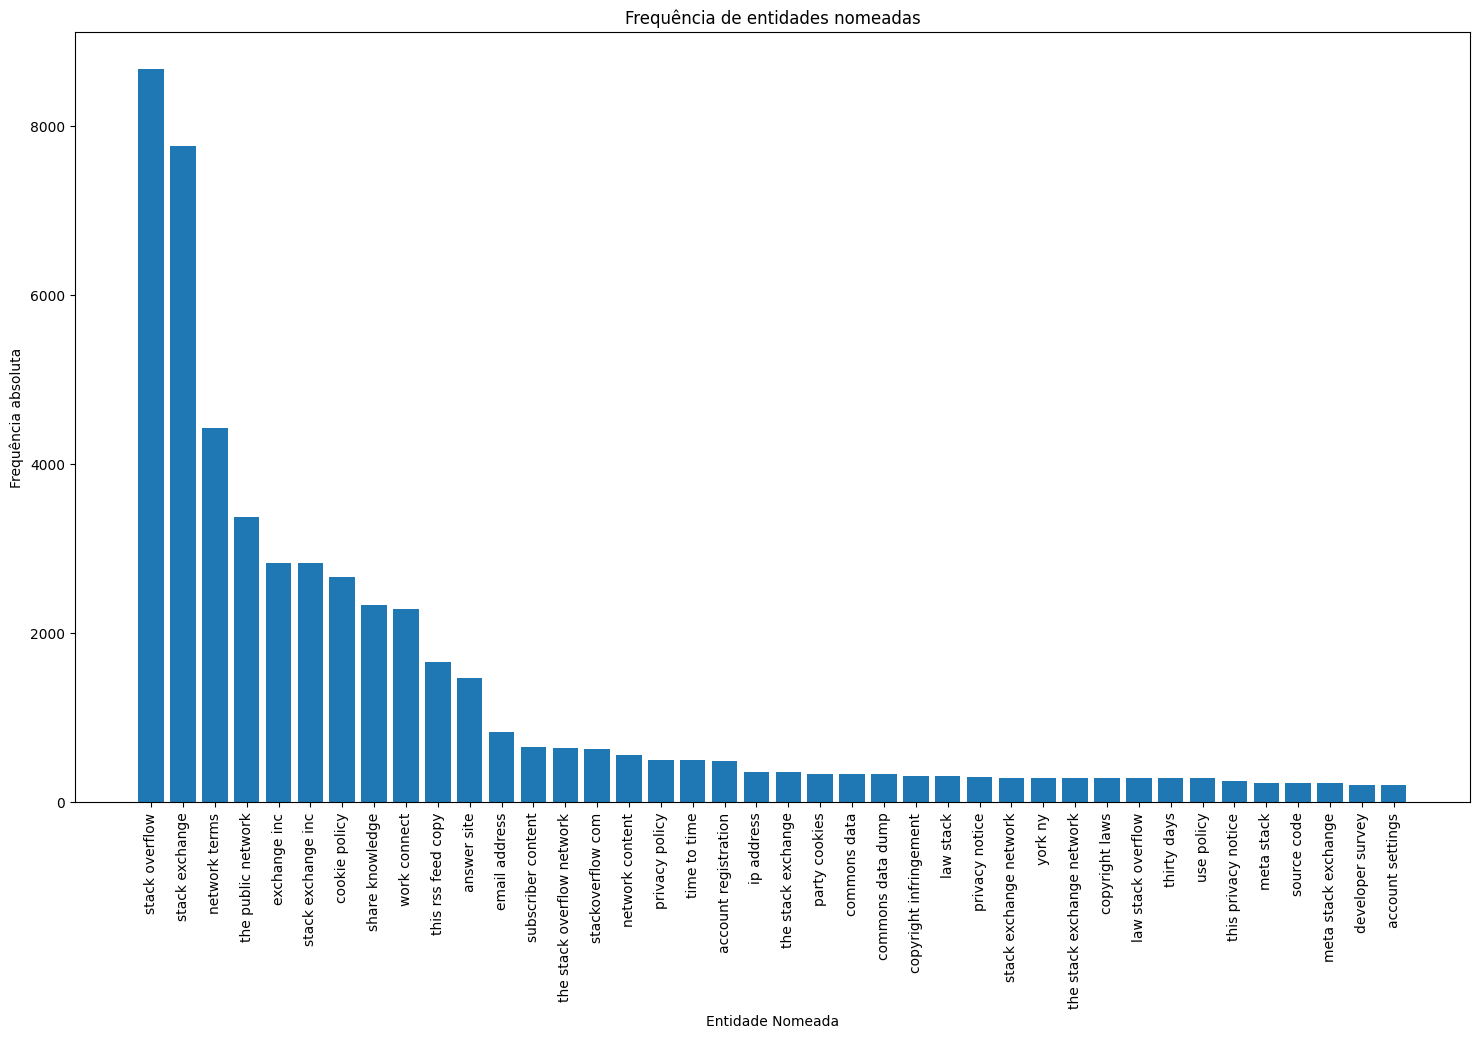

In [65]:
plt.figure(figsize=(18,10))
plt.bar(range(len(y)), y)
plt.xticks(range(len(y)), x, rotation=90)
plt.ylabel("Frequência absoluta")
plt.xlabel("Entidade Nomeada")
plt.title("Frequência de entidades nomeadas")
plt.show()


Analisando o gráfico produzido, é possível identificar duas principais entidades nomeadas, o Stack Overflow e o Stack Exchange. Também é possível identificar alguns assuntos proeminentes, como acesso de redes (the public network, ip address, network terms, cookies) que parecem ser problemas recorrentes nos assuntos relacionados a fazer web scraping em python. Anteriormente foi possível identificar entidades nomeadas como urllib2 e beautifulsoup, porém elas não parecem ter contagens altas, o que talvez pudesse ser resolvido alterando a Regex para descartar alguns falsos-positivos, ou ainda usando outra métrica, como tf-idf.